In [1]:
from ML_Dataset_Model import *
from ML_Functions import *
from Ariel_Functions import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import leastsq
import h5py 
from tqdm.notebook import tqdm
from time import time
import scipy
import torch
from torch import nn
from torch.utils.data import DataLoader
torch.set_default_dtype(torch.float64)

In [2]:
heads = ['planet_radius' ,	'planet_temp', 	'log_H2O', 	'log_CO2', 	'log_CO' ,	'log_CH4' 	,'log_NH3']
aux_heads = ['star_distance','star_mass_kg','star_radius_m','star_temperature','planet_mass_kg','planet_orbital_period','planet_distance','planet_surface_gravity']

In [3]:
# path = 'TrainingData'
# path_torch = ''

# test_matrix = to_observed_matrix(h5py.File( os.path.join( path,'SpectralData.hdf5'),'r') ,pd.read_csv( os.path.join( path,'AuxillaryTable.csv')))
# spec_tr = torch.Tensor(test_matrix[:,:,1])
# noise_tr = torch.Tensor(test_matrix[:,:,2])
# aux_tr = torch.Tensor(pd.read_csv( os.path.join( path,'AuxillaryTable.csv')).drop(pd.read_csv( os.path.join( path,'AuxillaryTable.csv')).columns[:1],axis=1).values)
# quart_tr = torch.tensor(pd.read_csv(os.path.join( path,'Ground Truth Package/QuartilesTable.csv')).drop('planet_ID',axis=1).values).reshape(-1,7,3).swapaxes(1,2)
# fm_tr =torch.tensor(pd.read_csv(os.path.join( path,'Ground Truth Package/FM_Parameter_Table.csv')).drop(['planet_ID','Unnamed: 0'],axis=1).values)
# del test_matrix

# torch.save({'Spectra':spec_tr,'Noise':noise_tr,'Aux':aux_tr,'Quart_tr':quart_tr,'FM':fm_tr},'tr_data.pt')



In [4]:
tr_coef =1.1

# T prediction Part

In [5]:
data = torch.load('tr_data.pt')
quart_tr = torch.Tensor(data['Quart_tr'])
safe = ~torch.isnan(quart_tr[:,0,0])
quart_tr = quart_tr

spec = torch.Tensor(data['Spectra'])
noise = torch.Tensor(data['Noise'])
aux = torch.Tensor(data['Aux'])
fm = torch.Tensor(data['FM'])


param_RpT = torch.zeros(spec.shape[0],5)

param_RpT[safe] = torch.cat([quart_tr[safe,1,:2],torch.load('params_RpT.pt')],axis=1)

param_RpT[~safe] = torch.cat( [torch.load('semi_That'),torch.rand((~safe).sum())[:,None]],axis=1)


torch.manual_seed(0)

ind_orig = torch.rand(safe.sum())<tr_coef
ind = torch.zeros(spec.shape[0])==0
ind[torch.where(safe)[0][~ind_orig] ] =False


In [6]:

def preprocessor_RpT(spec,aux,noise,ind=None,std_mn=None):

    # Modifying outliers
    for i in range(spec.shape[0]):
        
        spec[i,spec[i,:]>0.1] = (spec[i,spec[i,:]<0.1]/noise[i,spec[i,:]<0.1]).mean()*noise[i,spec[i,:]>0.1]
    R_j = 71492*1e3
    Rpj = torch.sqrt(spec.min(axis=1).values*aux[:,2]**2/R_j**2)
    Rp = Rpj.clone()*R_j
    
    # Calculate R_p/R_s for the next steps
    temp = ((Rp/aux[:,2]))[:,None]
    

    # Calculating the effective temperature and the scale height
    T = aux[:,3]*(1/2*aux[:,2]/(aux[:,6]*149597870.7*1000))**(1/2)
    H = 1.380649* T / (2.29*1.66054e-4*aux[:,7])
    
    # Getting rid of the bulk planet contribution
    spec_ = spec.clone()
    spec = (spec - temp**2)
    
    # Concatenate three unitless features to the auxillary data
    aux = torch.cat((aux,Rp[:,None],(Rp/aux[:,2])[:,None],
                        (aux[:,6]/H)[:,None],spec.max(axis=1).values[:,None] ,aux[:,2][:,None]/H[:,None]  ),axis=1) # *

    # aux = torch.cat((aux,Rp[:,None],(Rp/aux[:,2])[:,None],
    #                     spec.max(axis=1).values[:,None] ),axis=1) # *
    
    # Normalization of noise and spectra
    noise = noise/spec.max(axis=1).values[:,None]
    spec = spec/spec.max(axis=1).values[:,None]
    spec = torch.cat([spec,spec_],axis=1)
    # Calculate std and mean for the auxillary data if it is the training phase
    if std_mn is None:
        aux_std,aux_mn = aux[ind].std(axis=0),aux[ind].mean(axis=0)
        std_mn = [aux_std,aux_mn]
    
    else:
        aux_std,aux_mn = std_mn
       
    # Standardize the auxillary data
    aux = standardize(aux,aux_mn,aux_std) 
    
    return spec,aux,noise,Rpj,T,std_mn



In [7]:
spec_tr,aux_tr,noise_tr,Rp,T,std_mn_T = preprocessor_RpT(spec,aux,noise,ind=ind)
aux_std,aux_mn = std_mn_T

param_tr = param_RpT[:,[1,3]].clone()

param_mn,param_std = param_tr[ind].mean(axis=0)[None],param_tr[ind].std(axis=0)[None]


In [8]:
alphas = torch.ones(spec.shape[0])
alphas[~safe] = 0.2

In [9]:
train_data = Combined_Quart_Dataset(spectra=spec_tr[ind],aux=aux_tr[ind],quart=param_tr[ind],noise=noise_tr[ind],alphas=alphas[ind])
train_loader = DataLoader(train_data, batch_size=64,
                        shuffle=True, num_workers=0)

if not(ind.all()):
    test_data = Combined_Quart_Dataset(spectra=spec_tr[~ind],aux=aux_tr[~ind],quart=param_tr[~ind],noise=noise_tr[~ind],alphas=alphas[~ind])

else:
    test_data = Combined_Quart_Dataset(spectra=spec_tr[safe],aux=aux_tr[safe],quart=param_tr[safe],noise=noise_tr[safe],alphas=alphas[safe])

    
test_loader = DataLoader(test_data, batch_size=len(test_data),
                        shuffle=True, num_workers=0)


In [10]:
torch.manual_seed(0)
alpha=[torch.tensor([100,0.00001]),torch.tensor([6000,300])]
model_T = RpT_ML(alpha,Dropout=.0)

/home/e_/anaconda3/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [11]:
torch.ones(2)*alpha[1]+alpha[0]

tensor([6100.0000,  300.0000])

In [12]:
def loss_fn(y,yhat):
    return 1-ks_score_approx(y-1e-4,yhat)


epochs=np.array([20,20,30])
lrs=np.array([5e-4,2.5e-4,1e-4])

params={'model':model_T ,
      'loss_fn':loss_fn,
      'train_dl':train_loader,
      'val_dl':test_loader,
      'device':'cpu', 'optimizer':torch.optim.Adam(model_T.parameters(),5e-3),'lrs':lrs,'epochs':epochs}

a=train(**params)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Time total: 456.72 sec, Best Val. Loss:0.15607429071906329


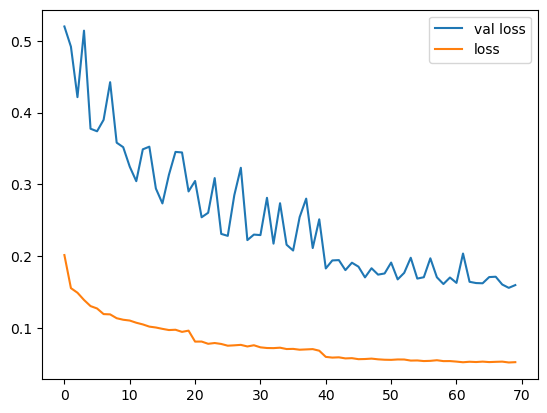

In [13]:
model_T.load_state_dict(a['state'])
model_T.eval()
plt.plot(a['history']['val_loss'],label='val loss')
plt.plot(a['history']['loss'],label='loss')
plt.legend()

# Rp Prediction

In [14]:

data = torch.load('tr_data.pt')
quart_tr = torch.Tensor(data['Quart_tr'])
safe = ~torch.isnan(quart_tr[:,0,0])
quart_tr = quart_tr [safe]# Only some of them have retrievals

spec = torch.Tensor(data['Spectra'])[safe]
noise = torch.Tensor(data['Noise'])[safe]
aux = torch.Tensor(data['Aux'])[safe]
fm = torch.Tensor(data['FM'])[safe]
param = torch.load('params_fixed.pt')
param_RpT = torch.load('params_RpT.pt')

torch.manual_seed(0)
ind = torch.rand(spec.shape[0])<tr_coef


In [15]:
spec_tr,aux_tr,noise_tr,Rp,T,std_mn_Rp = preprocessor_RpT(spec,aux,noise,ind=ind)
aux_std,aux_mn = std_mn_Rp

param_tr = torch.stack([quart_tr[:,1,0],param_RpT[:,0]],axis=1).clone()

param_mn,param_std = param_tr[ind].mean(axis=0)[None],param_tr[ind].std(axis=0)[None]


In [16]:
train_data = Combined_Quart_Dataset(spectra=spec_tr[ind],aux=aux_tr[ind],quart=param_tr[ind],noise=noise_tr[ind])
train_loader = DataLoader(train_data, batch_size=64,
                        shuffle=True, num_workers=0)

if not(ind.all()):
    test_data = Combined_Quart_Dataset(spectra=spec_tr[~ind],aux=aux_tr[~ind],quart=param_tr[~ind],noise=noise_tr[~ind])

else:
    test_data = train_data

    
test_loader = DataLoader(test_data, batch_size=len(test_data),
                        shuffle=True, num_workers=0)


In [17]:
torch.manual_seed(0)
alpha=[torch.tensor([1e-3,1e-7]),torch.tensor([2.5,1e-1])]
model_Rp = RpT_ML(alpha,Dropout=.0)

In [18]:
def loss_fn(y,yhat):
    return 1-ks_score_approx(y,yhat)
            
epochs=np.array([20,20,30])
lrs=np.array([5e-3,2.5e-3,8e-4])
lrs=np.array([5e-4,2.5e-4,1e-4])#*1/4

params={'model':model_Rp ,
      'loss_fn':loss_fn,
      'train_dl':train_loader,
      'val_dl':test_loader,
      'device':'cpu', 'optimizer':torch.optim.Adam(model_Rp.parameters(),5e-3),'lrs':lrs,'epochs':epochs}

a=train(**params)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

Time total: 71.45 sec, Best Val. Loss:0.4982142393880062


# Chemical Prediction

In [19]:
def preprocessor(spec,aux,noise,ind=None,std_mn=None):

    # Modifying outliers
    for i in range(spec.shape[0]):
        
        spec[i,spec[i,:]>0.1] = (spec[i,spec[i,:]<0.1]/noise[i,spec[i,:]<0.1]).mean()*noise[i,spec[i,:]>0.1]
    R_j = 71492*1e3


    Rp = torch.sqrt(spec.min(axis=1).values)*aux[:,2]
    Rpj =Rp.clone()/R_j
    
    # Calculate R_p/R_s for the next steps
    temp = ((Rp/aux[:,2]))[:,None]
    

    # Calculating the effective temperature and the scale height
    T = aux[:,3]*(1/2*aux[:,2]/(aux[:,6]*149597870.7*1000))**(1/2)
    H = 1.380649* T / (2.29*1.66054e-4*aux[:,7])
    
    # Getting rid of the bulk planet contribution
    
    
    spec = (spec - temp**2)
    spec[spec<0] = 1e-4
    # Concatenate three unitless features to the auxillary data
    aux = torch.cat((aux,Rp[:,None],(Rp/aux[:,2])[:,None],
                        (aux[:,6]/H)[:,None],spec.max(axis=1).values[:,None],aux[:,2][:,None]/H[:,None]  ),axis=1) # *

    # Normalization of noise and spectra
    noise = noise/spec.max(axis=1).values[:,None]
    spec = spec/spec.max(axis=1).values[:,None]

    # Calculate std and mean for the auxillary data if it is the training phase
    if std_mn is None:
        aux_std,aux_mn = aux[ind].std(axis=0),aux[ind].mean(axis=0)
        std_mn = [aux_std,aux_mn]
    
    else:
        aux_std,aux_mn = std_mn
       
    # Standardize the auxillary data
    aux = standardize(aux,aux_mn,aux_std) 
    
    return spec,aux,noise,Rpj,T,std_mn


In [20]:
spec_tr,aux_tr,noise_tr,Rp,T,std_mn = preprocessor(spec,aux,noise,ind=ind)
aux_std,aux_mn = std_mn
param_tr = torch.tensor(param).clone()

param_mn,param_std = param_tr[ind,:,:].mean(axis=0),param_tr[ind,:,:].std(axis=0)

In [21]:
train_data = Combined_Quart_Dataset(spectra=spec_tr[ind],aux=aux_tr[ind],quart=param_tr[ind][:,:,:],noise=noise_tr[ind])
train_loader = DataLoader(train_data, batch_size=64,
                        shuffle=True, num_workers=0)

if not(ind.all()):
    test_data = Combined_Quart_Dataset(spectra=spec_tr[~ind],aux=aux_tr[~ind],quart=param_tr[~ind][:,:,:],noise=noise_tr[~ind])

else:
    test_data=train_data
    
test_loader = DataLoader(test_data, batch_size=len(test_data),
                        shuffle=True, num_workers=0)


In [22]:
torch.manual_seed(0)
model = Parameter_ML(Dropout=0)


In [23]:
# Loss function is an approximation of the EMD

loss_fn = lambda y,yhat: ((yhat[:,0]-y[:,0]).abs()*1.5+(1-y[:,0]).abs()*torch.abs(y[:,1]-yhat[:,1]).abs()+(
    y[:,0])* ((y[:,2]-yhat[:,2])**2+ (torch.sqrt(y[:,3]+1e-7)-torch.sqrt(yhat[:,3]+1e-7) )**2 ).sqrt()).mean(axis=1)*5


lrs=np.array([5e-4,2.5e-4,1e-4])
epochs=np.array([20,25,5])

params={'model':model ,
      'loss_fn':loss_fn,
      'train_dl':train_loader,
      'val_dl':test_loader,
      'device':'cpu', 'optimizer':torch.optim.Adam(model.parameters(),5e-4),'lrs':lrs,'epochs':epochs}

a=train(**params)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Time total: 70.51 sec, Best Val. Loss:1.589221062770995


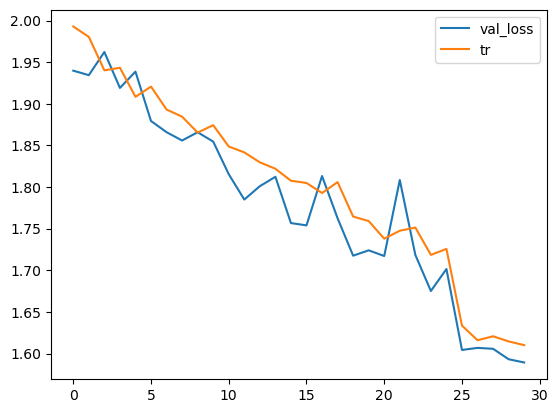

In [24]:
model.eval()
# model.load_state_dict(a['state'])
with torch.no_grad():params_test = model(spec_tr,aux_tr,noise_tr).numpy()
plt.plot(a['history']['val_loss'][20:],label='val_loss')
plt.plot(a['history']['loss'][20:],label='tr')
plt.legend()

# Calculates a part of the score 

In [25]:
ind_score = ind.clone()
if ind.all():
    torch.manual_seed(0)

    temp = torch.rand(safe.sum()).abs()>.8
    ind_score[temp]=False 
t2,w2 = to_matrix('../TrainingData/Ground Truth Package/Tracedata.hdf5',torch.where(safe)[0][torch.where(~ind_score)[0]])



In [31]:
spec_test,aux_test,noise_test,Rp,T,std_mn =  preprocessor(spec,aux,noise,std_mn=std_mn)
model.eval()
with torch.no_grad():params_test = model(spec_test,aux_test,noise_test).detach().numpy()

spec_test,aux_test,noise_test,Rp,T,std_mn_T =  preprocessor_RpT(spec,aux,noise,std_mn=std_mn_T)
model_T.eval()
with torch.no_grad():That = model_T(spec_test,aux_test,noise_test).detach()

spec_test,aux_test,noise_test,Rp,T,std_mn_Rp =  preprocessor_RpT(spec,aux,noise,std_mn=std_mn_Rp)
model_Rp.eval()
with torch.no_grad():Rphat = model_Rp(spec_test,aux_test,noise_test).detach()

q_Rp  = Rphat.clone()
q_Rp[:,0] = torch.minimum(q_Rp[:,0],Rp)
q_T   =  That.clone()
q_RpT = torch.stack([q_Rp,q_T],-1).swapaxes(1,2)

In [32]:
real = torch.stack([quart_tr[:,1,:2],(quart_tr[:,2,:2]-quart_tr[:,0,:2])/2],dim=1).mT

In [33]:
W,y_dist = sample_fast(params_test[~ind_score],q_RpT[~ind_score])

np.int = int
w = np.zeros((len(W),7))
for i in tqdm(range(len(W))):
    w[i] = compute_posterior_loss(y_dist[i].T, W[i], t2[i], w2[i], bounds_matrix=None)
print(w.mean(axis=0))
print(w.mean())

  0%|          | 0/1351 [00:00<?, ?it/s]

  0%|          | 0/1351 [00:00<?, ?it/s]

[0.49998727 0.83791295 0.85682398 0.88211162 0.90023938 0.86102813
 0.8528111 ]
0.8129877762503965


# Submission  

In [42]:
path = 'final_test_set_data'
test_matrix = to_observed_matrix(h5py.File( os.path.join( path,'SpectralData.hdf5'),'r') ,pd.read_csv( os.path.join( path,'AuxillaryTable.csv')))
spec = torch.Tensor(test_matrix[:,:,1])
noise = torch.Tensor(test_matrix[:,:,2])
aux = torch.Tensor(pd.read_csv( os.path.join( path,'AuxillaryTable.csv')).drop(pd.read_csv( os.path.join( path,'AuxillaryTable.csv')).columns[:1],axis=1).values)
del test_matrix

In [43]:
spec_test,aux_test,noise_test,Rp,T,std_mn =  preprocessor(spec,aux,noise,std_mn=std_mn)
model.eval()
with torch.no_grad():params_test = model(spec_test,aux_test,noise_test).detach().numpy()

spec_test,aux_test,noise_test,Rp,T,std_mn_T =  preprocessor_RpT(spec,aux,noise,std_mn=std_mn_T)
model_T.eval()
with torch.no_grad():That = model_T(spec_test,aux_test,noise_test).detach()

spec_test,aux_test,noise_test,Rp,T,std_mn_Rp =  preprocessor_RpT(spec,aux,noise,std_mn=std_mn_Rp)
model_Rp.eval()
with torch.no_grad():Rphat = model_Rp(spec_test,aux_test,noise_test).detach()

q_Rp  = Rphat.clone()
q_Rp[:,0] = torch.minimum(q_Rp[:,0],Rp)
q_T   =  That.clone()
q_RpT = torch.stack([q_Rp,q_T],-1).swapaxes(1,2)

N=5000
W,y_dist = sample_fast (params_test,q_RpT,N)

  0%|          | 0/1545 [00:00<?, ?it/s]

In [44]:
y_dist[:,0]= np.maximum(0,y_dist[:,0])
y_dist[:,0]= np.minimum(3,y_dist[:,0])

y_dist[:,1]= np.maximum(0,y_dist[:,1])
y_dist[:,1]= np.minimum(7000,y_dist[:,1])

y_dist[:,2:]= np.maximum(-12,y_dist[:,2:])
y_dist[:,2:]= np.minimum(-1 ,y_dist[:,2:])

In [45]:
[y_dist[:,i,:].max() for i in range(7)]

[2.578013059173591, 6696.650799241033, -1.0, -1.0, -1.0, -1.0, -1.0]

In [46]:
[y_dist[:,i,:].min() for i in range(7)]

[0.0, 0.0, -12.0, -12.0, -12.0, -12.0, -12.0]

In [65]:
to_competition_format(y_dist.swapaxes(2,1),W,name='final_submission_fake.hdf5',entry_name='Planet_public')

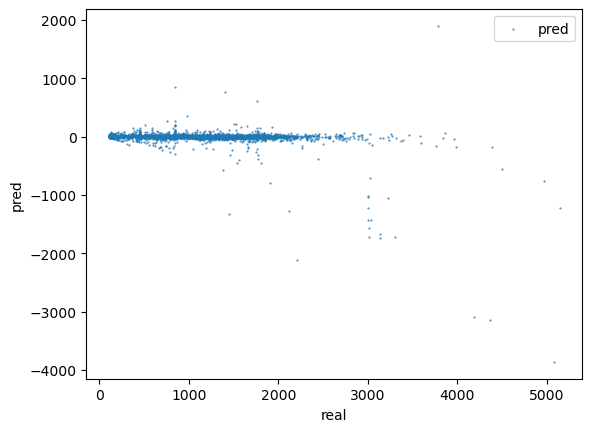

In [39]:
# plt.scatter(real[:,1,0],T,s=.2,label='eq. T')
plt.scatter(real[:,1,0],q_T[:,0]-real[:,1,0],s=.2,label='pred')
# plt.scatter(real[:,1,0],fm[:,1],s=.2,label='fm')
# plt.axis('equal')
plt.xlabel('real')
plt.ylabel('pred')
plt.legend()

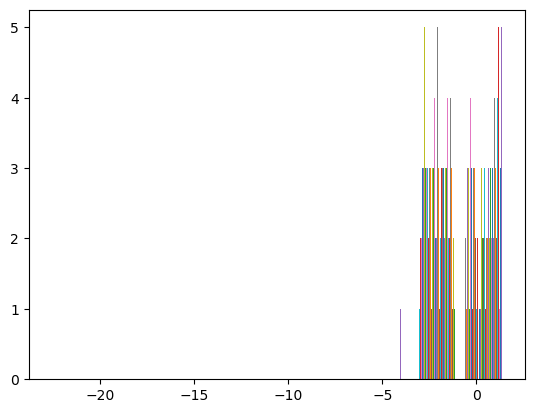

In [40]:
plt.hist(torch.log(param_tr[:,3]))
print('')

In [41]:
w_calc = ks_score_approx(real[~ind][:,1],q_RpT[~ind][:,1])

In [42]:
w_calc.mean()

tensor(nan)

Default:[0.47114671 0.59678253 0.86394049 0.88415736 0.90094138 0.86220563 0.84583109] 0.77500074019245


In [191]:
# torch.save(model.state_dict(),'model_copy_682_params.pt')
# torch.save(model_RpT.state_dict(),'model_RpT_copy_682_params.pt')

In [380]:
w.mean(axis=0)

array([0.03688038, 0.76968986, 0.86412835, 0.88420785, 0.90098194,
       0.86202295, 0.84607506])

tensor([[0.1944, 0.1312]])


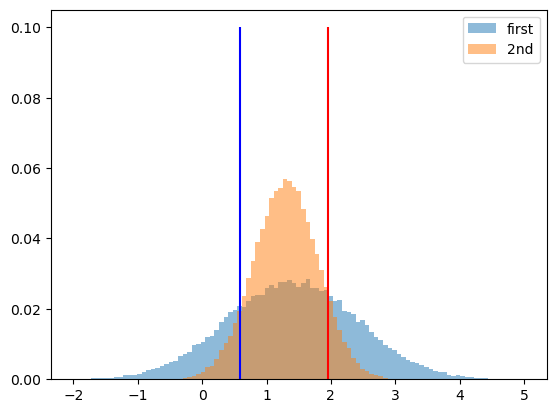

In [206]:
y= torch.tensor([1.4,1])[None,:]
yhat= torch.tensor([1.3,.5])[None,:]
m1,std1=torch.split(y,[1,1],dim=1)
m2,std2=torch.split(yhat,[1,1],dim=1)
N=50000
bins = np.linspace(-2,5,100)
a=(1/std2**2-1/std1**2)
b=2*(m1/std1**2-m2/std2**2)
c=2*torch.log(std2/std1)+(m2**2/std2**2-m1**2/std1**2)
x = solve_quadratic(torch.cat([a,b,c],dim=1))
plt.hist(torch.normal(y[:,0],y[:,1].broadcast_to(N)),weights=1/N*np.ones(N),bins=bins,cumulative=False,alpha=.5,label='first')
plt.hist(torch.normal(yhat[:,0],yhat[:,1].broadcast_to(N)),weights=1/N*np.ones(N),bins=bins,cumulative=False,alpha=.5,label='2nd')
plt.legend()
plt.vlines(x[0,1],0,.1,'b')
plt.vlines(x[0,0],0,.1,'r')
print((torch.erf( (x-m1)/(std1*1.414) )-torch.erf( (x-m2)/std2*1/1.414 )).abs()*1/2)

In [210]:
w_calc = ks_score_approx(real[~ind][:,0],q_RpT[~ind][:,0])

In [145]:
w_calc.shape

torch.Size([1351, 2])

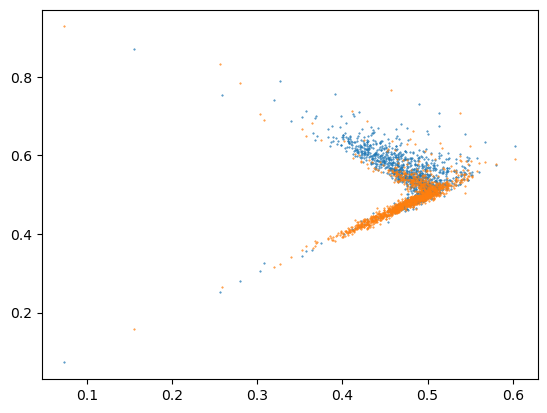

In [146]:
plt.scatter(w[:,0],w_calc[:,0],s=.2)
plt.scatter(w[:,0],w_calc[:,1],s=.2)

Text(0.5, 0, '$w_{ariel}$')

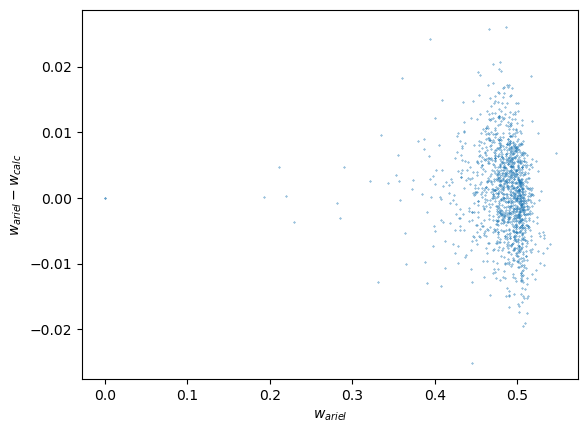

In [214]:
plt.scatter(w[:,0],w_calc-w[:,0],s=.1)
plt.ylabel('$w_{ariel}-w_{calc}$')
plt.xlabel('$w_{ariel}$')

# plt.(w[:,0],w_calc.min(axis=1).values,s=.2)

# plt.scatter(w[:,0],w_calc[:,1],s=.2)

tensor([696.5810])
0.5873200197756577


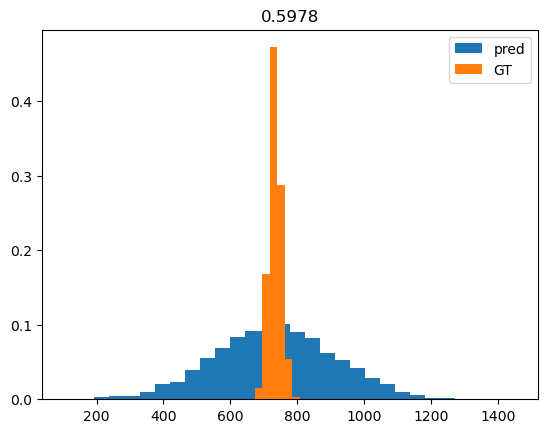

In [55]:
i=899
j=1
plt.title(w[i,j])
plt.hist(y_dist[i][j],weights=W[i]/W[i].sum(),bins=30,label='pred')
plt.hist(t2[i][:,j],weights=w2[i]/w2[i].sum(),bins=30,label='GT')

plt.plot()
plt.legend()
print(ks_score_approx(real[~ind][[i],j],q_RpT[~ind][[i],j]).item())
# plt.scatter(y_dist[0,0],)

Text(0, 0.5, 'Predicted Q2')

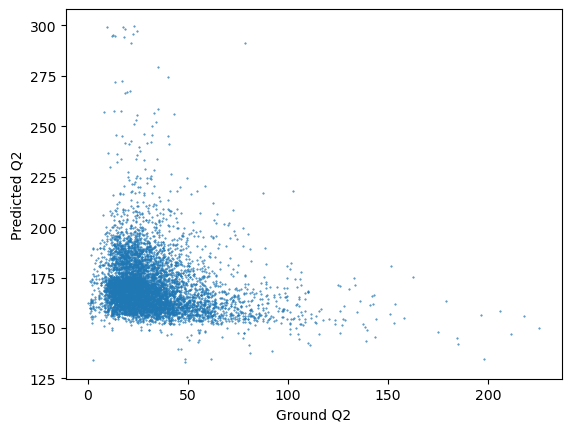

In [132]:
plt.scatter((quart_tr[:,2,1]-quart_tr[:,0,1])/2,q_T[:,1],s=.2)
plt.xlabel('Ground Q2')
plt.ylabel('Predicted Q2')


Text(0, 0.5, 'Predicted Q2')

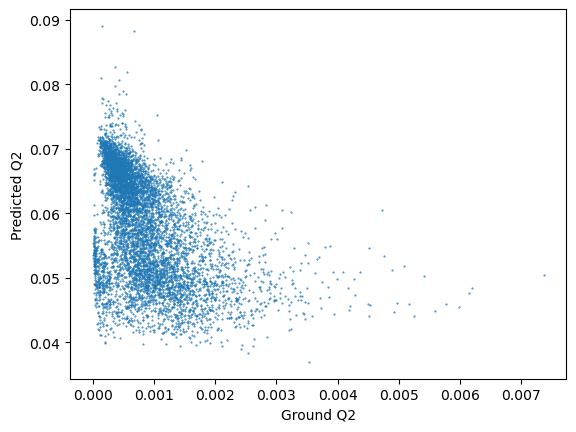

In [56]:
plt.scatter((quart_tr[:,2,0]-quart_tr[:,0,0])/2,q_Rp[:,1],s=.2)
plt.xlabel('Ground Q2')
plt.ylabel('Predicted Q2')


(array([  29.,  117.,  196.,  431., 1587.,  358.,  101.,   46.,   17.,
           2.]),
 array([ 462.9556356 ,  551.28956684,  639.62349807,  727.95742931,
         816.29136054,  904.62529178,  992.95922301, 1081.29315425,
        1169.62708548, 1257.96101671, 1346.29494795]),
 <BarContainer object of 10 artists>)

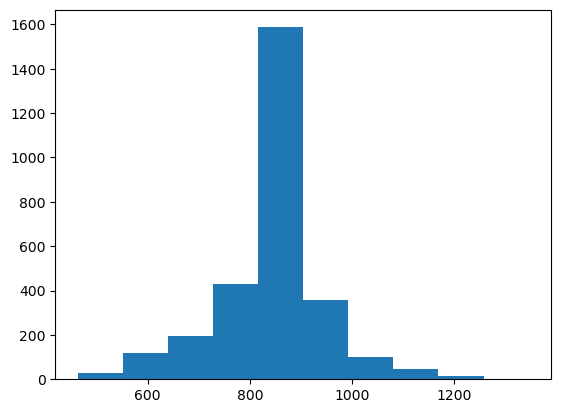

In [424]:
plt.hist(t2[i][:,1])

In [494]:
torch.save(q_T,'T_guesses')

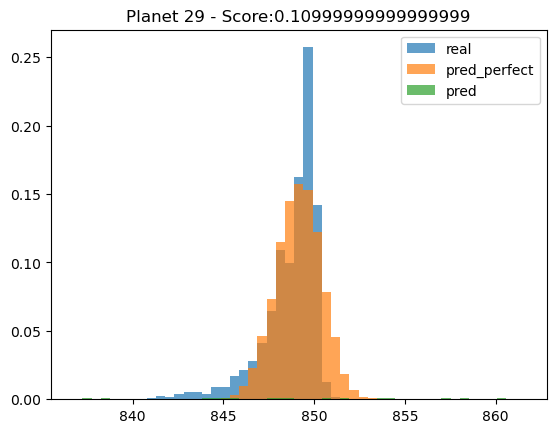

In [492]:
i-=1
# i=9
x=torch.linspace(-1,1,50)*10*real[~ind_score][i,1,1]+real[~ind_score][i,1,0]
N=5000
alp = .7
plt.hist(t2[i][:,1],weights=w2[i],alpha=alp,bins=x,label='real')
plt.hist(torch.normal(real[~ind_score][i,1,0],real[~ind_score][i,1,1].broadcast_to(N)),weights=1/N*torch.ones(N)\
         ,bins=x,alpha=alp,label='pred_perfect')
plt.hist(torch.normal(q_T[~ind_score][i,0],q_T[~ind_score][i,1].broadcast_to(N)),weights=1/N*torch.ones(N),bins=x,alpha=alp,\
        label='pred')
plt.legend()
plt.title('Planet '+str(i)+' - Score:'+str(w[i][1]))
i+=1

plt.show()

Text(0, 0.5, '$(Q2_T-\\hat Q2_R)/\\sigma_T$')

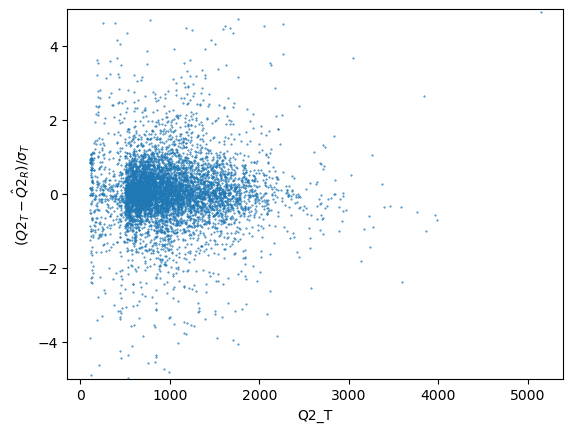

In [379]:
plt.scatter(real[:,1,0],(real[:,1,0]-q_T[:,0])/real[:,1,1],s=.2)
plt.xlabel('Q2_T')
plt.ylim([-5,5])
plt.ylabel('$(Q2_T-\hat Q2_R)/\sigma_T$')

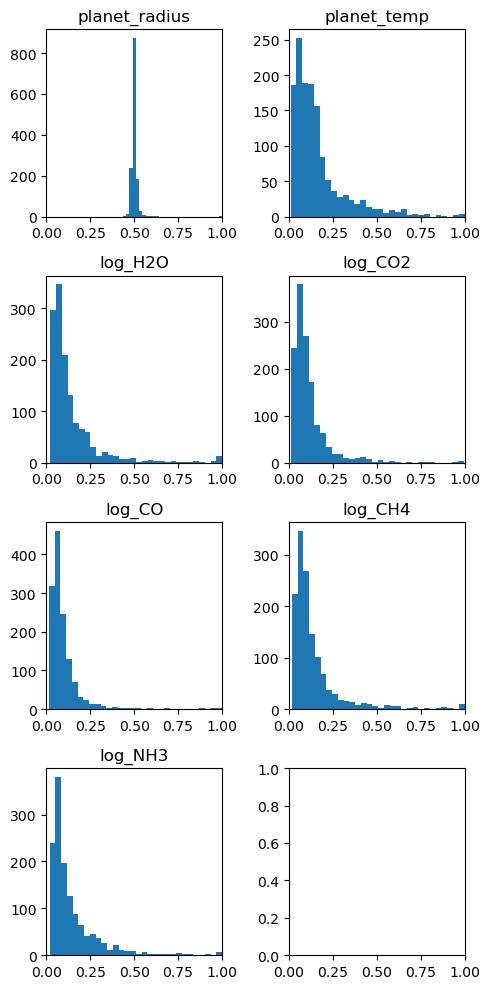

In [44]:
fig,ax = plt.subplots(4,2,figsize=(5,10))
ax = ax.flatten()
for i in range(7):
    ax[i].hist(1-w[:,i],bins=30)
    ax[i].set_xlim([0,1])
    ax[i].set_title(heads[i])
fig.tight_layout()

In [30]:
# without augmentation [0.48182147 0.50739482 0.80345566 0.83099556 0.86994064 0.80337942
#  0.8111926 ]
# 0.7297400232631913
# it is 74.9 with aug